# 17기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

# 0. 모듈 불러오기

In [43]:
# 데이터 전처리
import numpy as np
import pandas as pd
import math

# 기계학습 모델(군집화) 생성, 학습, 평가
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['axes.unicode_minus'] = False

## 1. 데이터 불러오기

In [2]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.shape

(200, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [5]:
for i in range(len(df.columns)):
    print(df.columns[i])
    print(df[df.columns[i]].unique())
    print()

Gender
['Male' 'Female']

Age
[19 21 20 23 31 22 35 64 30 67 58 24 37 52 25 46 54 29 45 40 60 53 18 49
 42 36 65 48 50 27 33 59 47 51 69 70 63 43 68 32 26 57 38 55 34 66 39 44
 28 56 41]

Annual Income (k$)
[ 15  16  17  18  19  20  21  23  24  25  28  29  30  33  34  37  38  39
  40  42  43  44  46  47  48  49  50  54  57  58  59  60  61  62  63  64
  65  67  69  70  71  72  73  74  75  76  77  78  79  81  85  86  87  88
  93  97  98  99 101 103 113 120 126 137]

Spending Score (1-100)
[39 81  6 77 40 76 94  3 72 14 99 15 13 79 35 66 29 98 73  5 82 32 61 31
 87  4 92 17 26 75 36 28 65 55 47 42 52 60 54 45 41 50 46 51 56 59 48 49
 53 44 57 58 43 91 95 11  9 34 71 88  7 10 93 12 97 74 22 90 20 16 89  1
 78 83 27 63 86 69 24 68 85 23  8 18]



* 4개의 Column으로 이루어진 고객 200명의 데이터셋임.
* 결측치 x
* `Gender`은 Categorical, `Age`, `Annual Income (k$)`, `Spending Score (1-100)`은 Numerical임.

* `Gender`은 Categorical이기에 One-hot-encoding을 진행함.

In [6]:
encoder = OneHotEncoder().fit(df[['Gender']])

In [7]:
encoded_data = pd.DataFrame(encoder.transform(df[['Gender']]).toarray(), index = df.index, columns = encoder.get_feature_names(['Gender']))

data = pd.concat([df, encoded_data], sort = False, axis=1).drop(['Gender'], axis=1)

data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0


<AxesSubplot:xlabel='Age', ylabel='Density'>

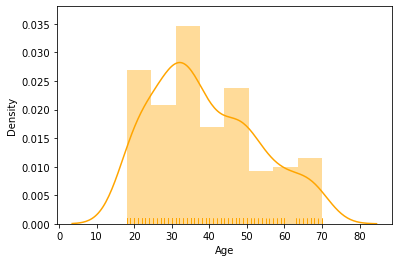

In [8]:
# Age
sns.distplot(data['Age'], kde=True, rug=True, color='orange')

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Density'>

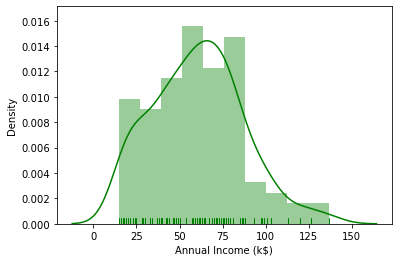

In [9]:
# Annual Income (k$)
sns.distplot(data['Annual Income (k$)'], kde=True, rug=True, color='green')

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Density'>

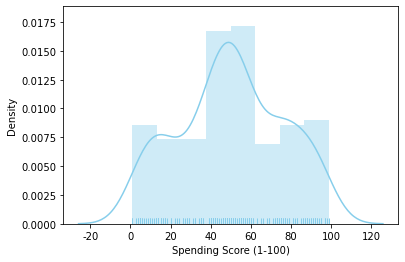

In [10]:
# Spending Score (1-100)
sns.distplot(data['Spending Score (1-100)'], kde=True, rug=True, color='skyblue')

<AxesSubplot:xlabel='Gender', ylabel='count'>

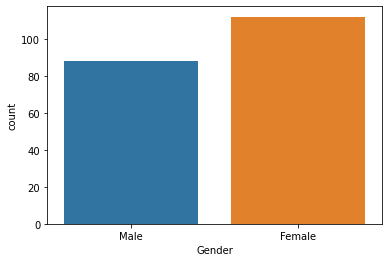

In [11]:
# Gender
sns.countplot(df['Gender'])

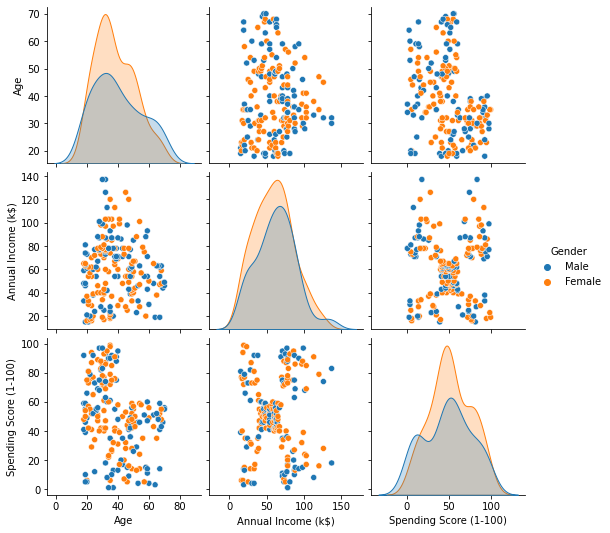

In [12]:
# Feature 간 관계 파악

sns.pairplot(df, hue='Gender')
plt.show()

<AxesSubplot:title={'center':'Correlation'}>

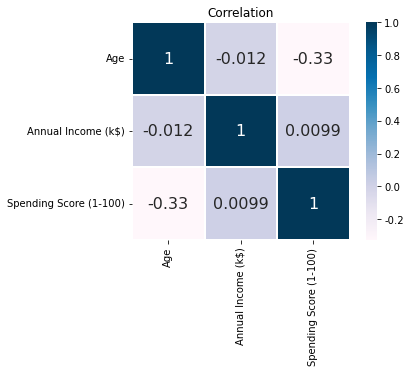

In [13]:
heatmap_data = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

colormap = plt.cm.PuBu
plt.title('Correlation')
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot = True, annot_kws = {'size':16})

* 평균적으로 남성은 여성보다 약간 나이가 많고 소득이 높은 경향이 있는 반면 여성은 남성보다 지출이 많은 경향이 있음.

* 상관관계에 따르면 데이터 집합 변수는 서로 강한 관계를 가지지는 않음. 연령과 지출점수 사이에는 -0.33이라는 약한 음의 연관성이 있으며 고객이 나이가 들수록 젊은 고객보다 지출이 적은 경향이 있음.

* 연소득과 소비점수의 조합은 뚜렷하게 군집을 형성할 수 있음

    1) 연 소득과 소비 점수가 모두 높은 군집(High-High)
    
    2) 연 소득은 높고 소비 점수는 낮은 군집(High-Low)
    
    3) 연 소득은 낮고 소비 점수는 높은 군집(Low-High)
    
    4) 연 소득과 소비 점수 모두 낮은 군집(Low-Low)
    
    5) 연 소득과 소비 점수가 모두 중간 수준인 군집(Medium-Medium)
    

* Level이 High, Medium, Low로 나눠지면 최대 군집 수는 3*3 = 9개임

# 2. 생성된 데이터셋에 군집화 알고리즘 적용

## 2.1 Hierarchical Clustering(계층적 군집화)

* 여러 개의 군집 중에서 가장 유사도가 높은 군집 2개를 선택하여 하나로 합치면서 군집 개수를 줄여나가는 방법

* 덴드로그램을 이용해 개별 개체들을 순차적/계층적으로 유사한 개체/군집과 통합함.

* 사전에 군집의 수를 정하지 않아도 수행 가능

1. 거리를 측정하는 방법

    * L1 norm(manhattan distance)
    
    * L2 norm(euclidean distance)
    
    * mahalanobis(feature간 공분산 행렬을 고려한 거리)
    
    * corr distance(상관계수 높을수록 거리 짧음)
    

2. cluster 간의 거리를 측정하는 방법

    * single linkage(군집 간 요소끼리 거리 중 min을 군집 간 거리로 설정)
    
    * complete linkage(군집 간 요소끼리 거리 중 max를 군집 간 거리로 설정)
    
    * average linkage(군집 간 요소끼리의 모든 거리를 average)
    
    * centroid(군집의 centroid끼리의 거리)
    
    * ward(두 군집 간 제곱합 - 군집 내 제곱합의 합)

**`Annual Income (k$)`, `Spending Score (1-100)`기준 clustering**

In [14]:
# data에서 Annual Income (k$), Spending Score (1-100) column만 추출

data1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]
data1.head()

,Annual Income (k$),Spending Score (1-100)
CustomerID,,
1,15,39
2,15,81
3,16,6
4,16,77
5,17,40


In [15]:
# data1 scaling

scaler = StandardScaler()
scaler.fit(data1)
data1_scaled = pd.DataFrame(scaler.transform(data1))
data1_scaled.columns = ['Annual Income (k$)', 'Spending Score (1-100)']
data1_scaled.head()

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


scaling을 적용한 데이터를 이용해 순서대로 single linkage, complete linkage, average linkage, centroid linkage, ward linkage를 적용함.

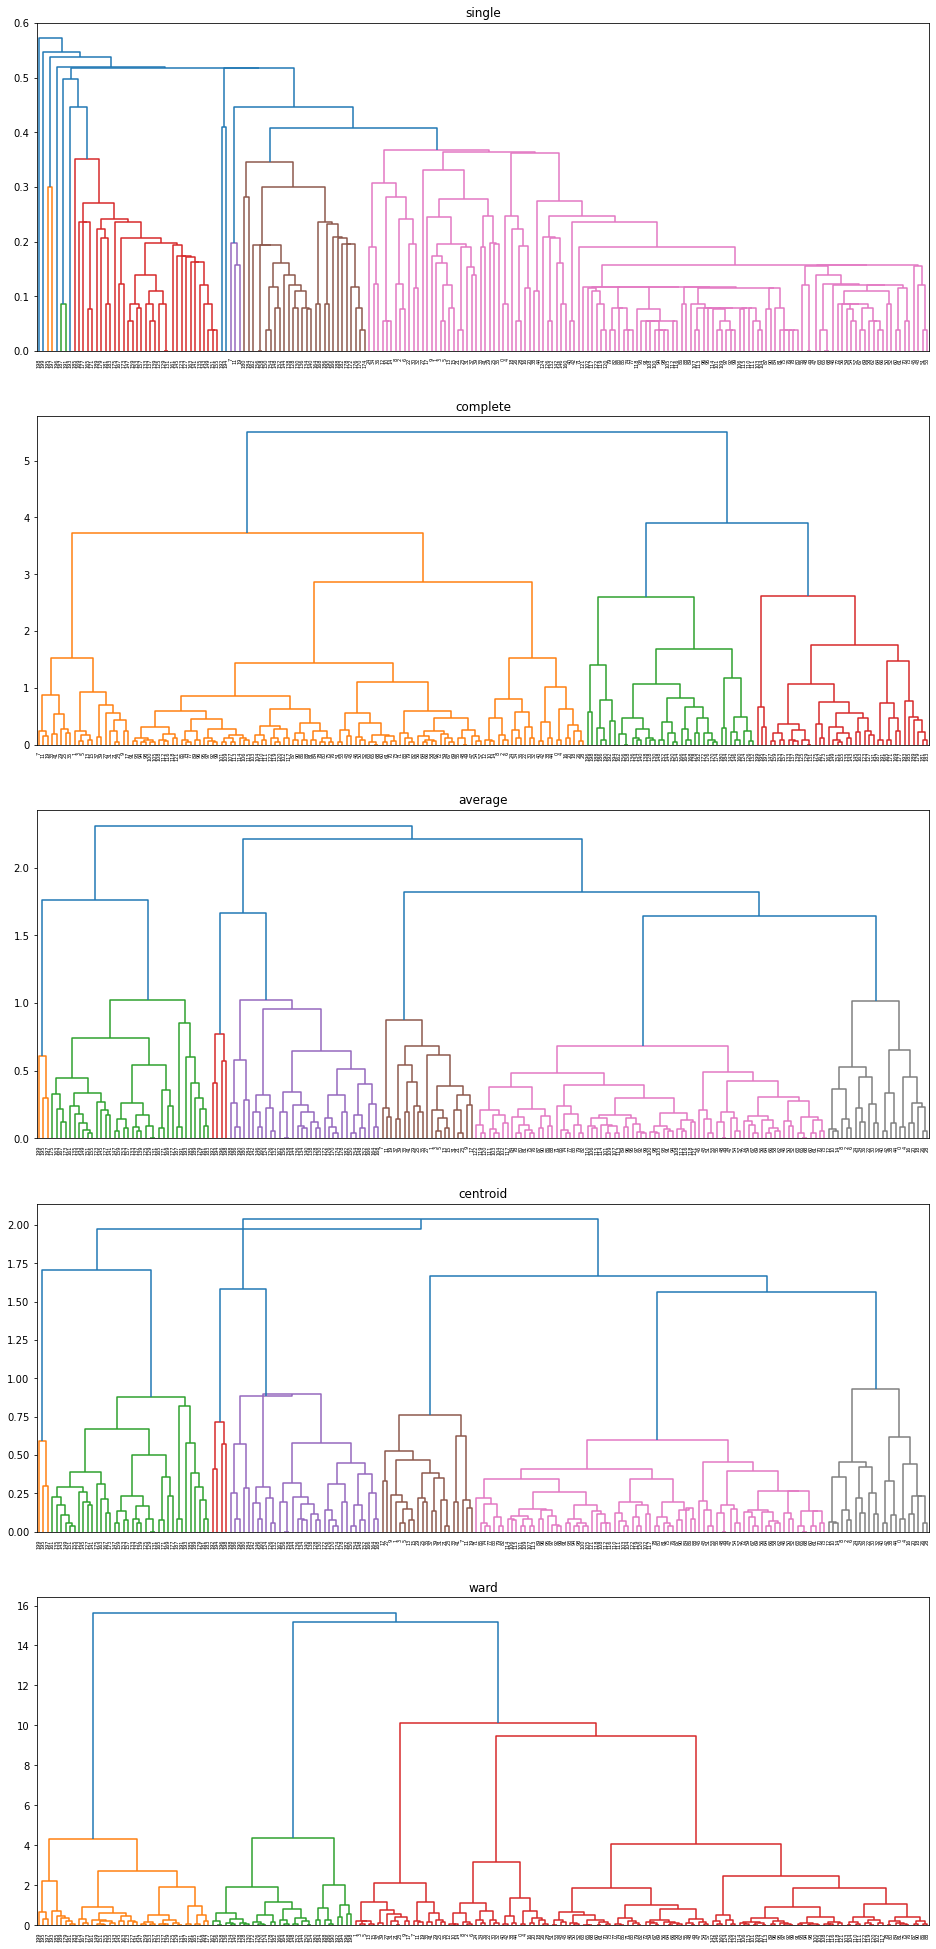

In [16]:
linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']

fig, axes = plt.subplots(nrows=len(linkage_list), figsize=(16,35))

for i in range(len(linkage_list)):
    hierarchical_single = linkage(data1_scaled, method=linkage_list[i])
    dn = dendrogram(hierarchical_single, ax=axes[i])
    axes[i].title.set_text(linkage_list[i])
    
plt.show()

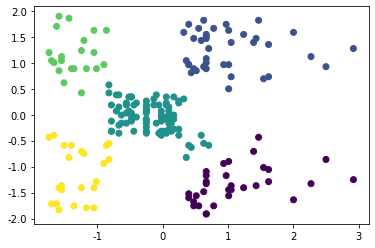

In [17]:
# ward
# 클러스터 개수는 가장 군집이 뚜렷하게 구분되었던 5개로 설정함.

agg_ward = AgglomerativeClustering(n_clusters=5)
cluster_pred_1 = agg_ward.fit_predict(data1_scaled)

plt.scatter(data1_scaled['Annual Income (k$)'], data1_scaled['Spending Score (1-100)'], c=cluster_pred_1)
plt.show()

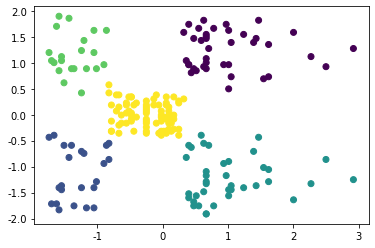

In [18]:
# complete

agg_complete = AgglomerativeClustering(n_clusters=5, linkage='complete')
cluster_pred_2 = agg_complete.fit_predict(data1_scaled)

plt.scatter(data1_scaled['Annual Income (k$)'], data1_scaled['Spending Score (1-100)'], c=cluster_pred_2)
plt.show()

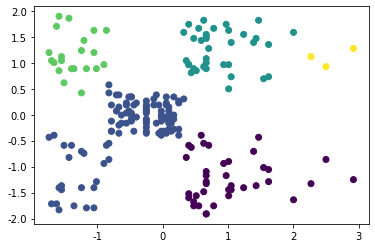

In [19]:
# average

agg_average = AgglomerativeClustering(n_clusters=5, linkage='average')
cluster_pred_3 = agg_average.fit_predict(data1_scaled)

plt.scatter(data1_scaled['Annual Income (k$)'], data1_scaled['Spending Score (1-100)'], c=cluster_pred_3)
plt.show()

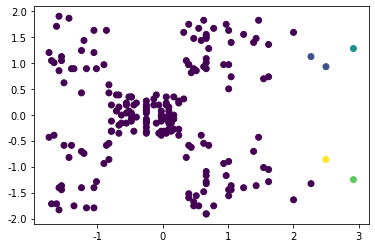

In [20]:
# single

agg_single = AgglomerativeClustering(n_clusters=5, linkage='single')
cluster_pred_4 = agg_single.fit_predict(data1_scaled)

plt.scatter(data1_scaled['Annual Income (k$)'], data1_scaled['Spending Score (1-100)'], c=cluster_pred_4)
plt.show()

* **Ward**와 **Complete**를 기준으로 클러스터링을 진행한 경우 군집이 더 잘 나뉘어진 것으로 보임. 따라서 **Ward**와 **Complete**를 군집 간 거리 측정 기준으로 삼는 것이 타당함.

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

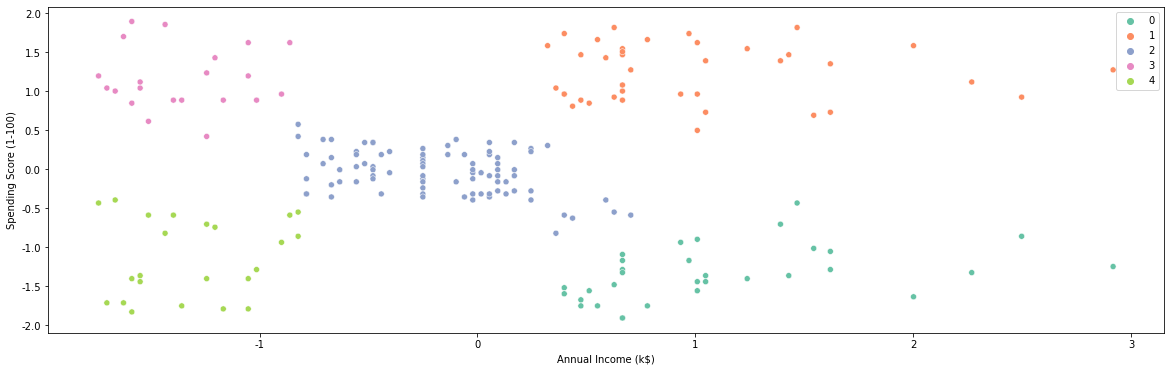

In [21]:
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = agg_clustering.fit_predict(data1_scaled)

plt.figure(figsize=(20,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data1_scaled, hue=labels, palette='Set2')

## 2.2 KMeans

* 비계층적 군집화 방법 중 distance 기반 알고리즘
* k개의 init centroid를 설정한 후 각각의 데이터에 가까운 centroid cluster로 할당한 후, cluster 내 centroid를 update하고, 다시 각각의 데이터를 가까운 centroid cluster로 할당하는 과정을 centroid가 변하지 않을 때까지 반복함. 
* Kmeans에서 중요한 변수는 군집의 개수인 **K**와 **init centroid**임. init centroid가 어디인지에 따라 최종 수렴된 clustering 결과가 달라질 수 있기 때문에 일부 데이터를 sampling해 hierarchical clustering을 수행한 후, 이에 기반해 init centroid를 지정하기도 함.
* scikit learn의 KMeans `k-means++` 방법으로 초기 centroid를 결정하는데, k개의 초기 centroid를 결정할 때 centroid_1 하나를 지정하고 다음 centroid_2는 이전의 centroid_1과 멀리 떨어지게 잡음. 군집 수인 K는 x축을 K, y축을 군집 내 거리 제곱합의 합으로 두고 급격하게 꺽이는 elbow point를 찾음.

In [22]:
# k에 따라 inertia_(군집 내 거리제곱합의 합)이 어떻게 변하는지 시각화

def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data1_scaled)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1, figsize=(12,6))
    plt.plot(n_clusters, sum_of_squared_distance, 'o')
    plt.plot(n_clusters, sum_of_squared_distance, '-', alpha=0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

In [23]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

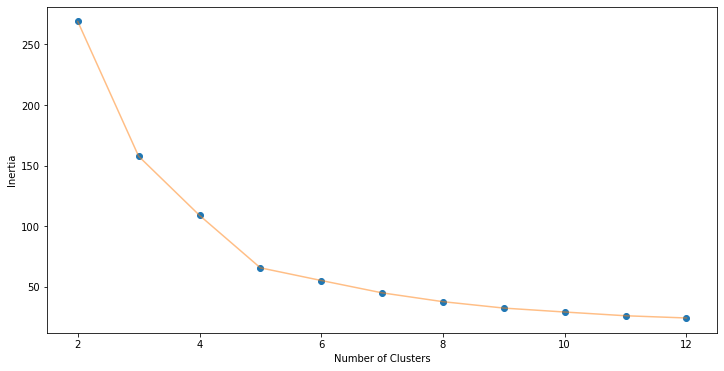

In [24]:
change_n_clusters(n_clusters, data1_scaled)

* 5정도가 elbow point로 보임.

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

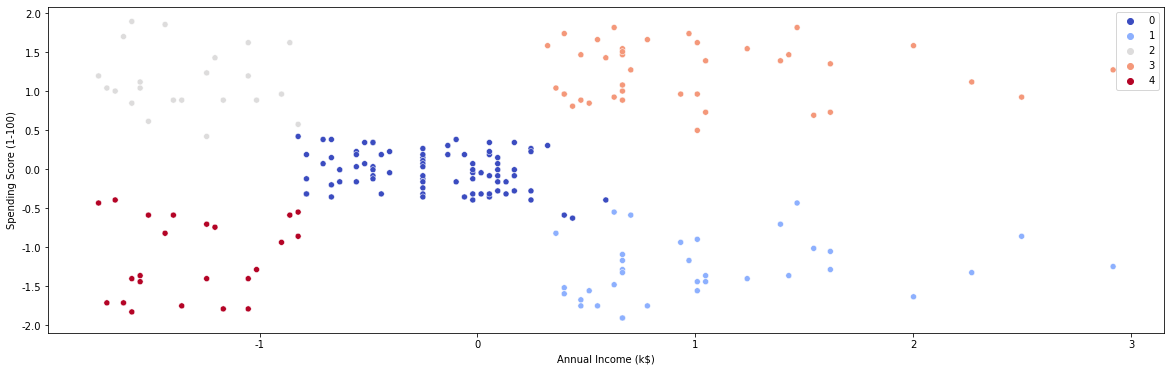

In [25]:
# scaling한 데이터를 kmeans(k=5)으로 학습하고 시각화

kmeans = KMeans(n_clusters=5)
kmeans.fit(data1_scaled)

plt.figure(figsize=(20,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data1_scaled, hue=kmeans.labels_, palette='coolwarm')

## 2.3 DBSCAN

* partitional clustering에 속하며 밀도 기반 알고리즘
* 중요한 하이퍼파라미터는 `minpts`와 `eps`임. eps, minpts에 기반해 모든 데이터를 core point, border point, noise point로 구분함.

    * **core point** : eps 반경 내에 minpts 이상개의 데이터 보유
    
    * **border point** : eps 반경 내에 minpts개의 데이터는 없지만, core point를 이웃으로 가짐
    
    * **noise point** : eps 반경 내에 minpts개의 데이터도 없고, core point도 이웃으로 가지지 않음.
    
* core point가 다른 core point의 eps 반경내에 포함되면 하나의 cluster가 되는 방향으로 군집을 형성해 나감. 이 때 border point는 cluster의 경계를 형성하는 역할을 하며, noise point는 어떤 cluster에도 포함되지 않음.

* eps와 minpts는 k-dist를 통해 적절한 값이 결정됨. 각 데이터마다 k번째로 가까운 거리를 구하고, 이 거리를 정렬하여 plot을 그림. 이 때 급격히 k-dist가 증가할 때 이 때의 dist값이 eps가, k가 minpts가 됨.

In [27]:
db_data = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
db_data.head()

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


In [28]:
# Scaling
scaler = StandardScaler()
scaler.fit(db_data)
db_data_scaled = pd.DataFrame(scaler.transform(db_data), columns = db_data.columns)
db_data_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


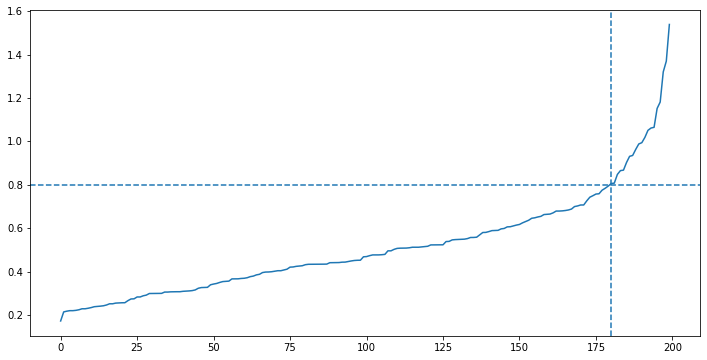

In [38]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(db_data_scaled)
distances, indices = neigh.kneighbors(db_data_scaled)

plt.figure(figsize=(12,6))
plt.plot(np.sort(distances[:,4]))
plt.axvline(180, 0, 2, ls='--')
plt.axhline(0.8, 0, 200, ls='--')

* 그래프가 급격히 4-dist가 증가하는 지점에서 eps 설정(0.8일 때 급증)

* distance인 0.8을 eps로, 4를 minpts로 잡고 DBSCAN 진행

In [39]:
dbscan = DBSCAN(eps=0.8, min_samples=4)
dbscan.fit(db_data_scaled)
print(np.unique(dbscan.labels_))

[-1  0]


<AxesSubplot:xlabel='Age', ylabel='Annual Income (k$)'>

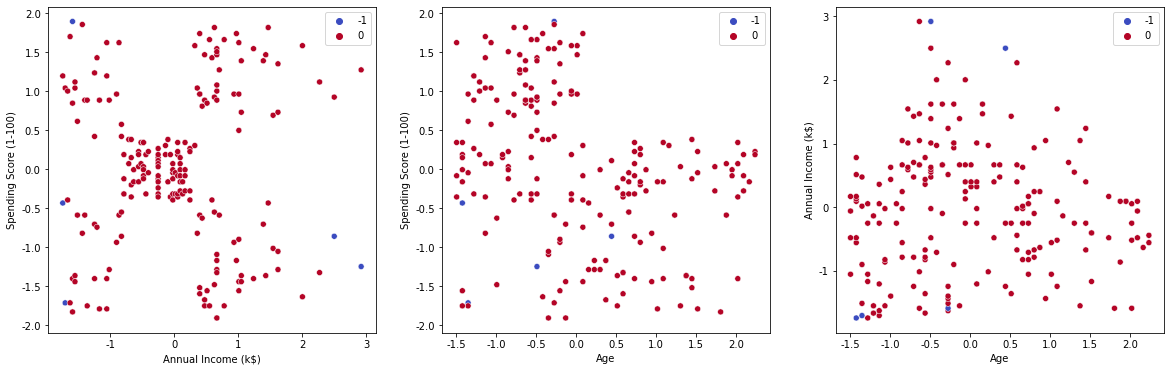

In [41]:
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=db_data_scaled, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=db_data_scaled, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=db_data_scaled, hue=dbscan.labels_, palette='coolwarm')

* 2개의 군집으로 분류되었지만 대부분 cluster 0에 속함.
* 군집별 밀도가 일정하지 않아 결과가 좋지 않은 것으로 예상됨.

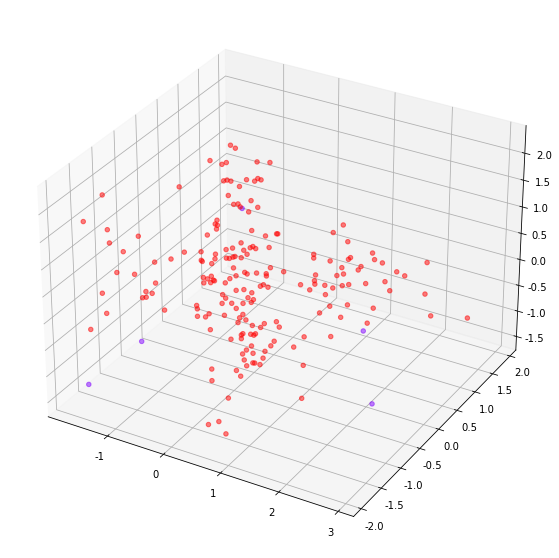

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = db_data_scaled['Annual Income (k$)']
y = db_data_scaled['Spending Score (1-100)']
z = db_data_scaled['Age']
ax.scatter(x, y, z, c=dbscan.labels_, s=20, alpha=0.5, cmap='rainbow')

# 3 Evaluation

In [52]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수
def visualize_silhouette(clustering, X_features, cluster_lists=[1]):
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        if clustering[0] == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_cluster, linkage=clustering[1])
        elif clustering[0] == 'kmeans':
            model = KMeans(n_clusters=n_cluster)
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        cluster_labels = model.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                          'Silhouette Score : ' + str(round(sil_avg, 3)))
        axs[ind].set_xlabel('The silhouette coefficient values')
        axs[ind].set_ylabel('Cluster label')
        axs[ind].set_xlim([-0.1,1])
        axs[ind].set_ylim([-1, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                  facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color='red', linestyle='--')

In [48]:
params = {
    'linkage':['single', 'complete', 'average', 'ward'],
    'n_clusters':[2, 3, 4, 5, 6, 7]}

scores_hierarcical= {}
for linkage in params['linkage']:
    for n_cluster in params['n_clusters']:
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(data1)
        score = silhouette_score(data1, hierarchical.labels_)
        scores_hierarcical['_'.join(['original', linkage, str(n_cluster)])] = score
        
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(data1_scaled)
        score = silhouette_score(data1_scaled, hierarchical.labels_)
        scores_hierarcical['_'.join(['scaling', linkage, str(n_cluster)])] = score

pd.Series(scores_hierarcical).sort_values(ascending=False)[:10]

scaling_ward_5         0.553809
scaling_complete_5     0.553112
original_ward_5        0.552995
original_complete_5    0.552995
scaling_complete_6     0.544086
original_complete_6    0.543666
original_average_7     0.539401
scaling_average_7      0.539258
scaling_ward_6         0.538676
original_ward_6        0.538021
dtype: float64

* scaling한 데이터에 ward를 적용한 5개의 cluster가 가장 점수가 높은 것으로 나타남.

* 실루엣 지수 해석 시 silhouette score만 좋다고 해서 좋은 clustering이라고 판단하면 안됨. 한 cluster silhouette 지수가 좋아서 전반적인 silhouette score가 높다면 clustering이 잘 되었다고 해석하기에는 무리가 있기 때문임. 

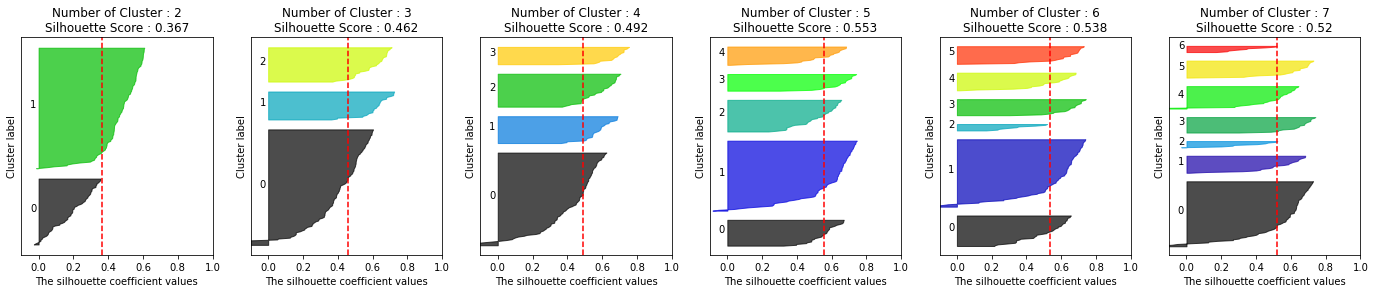

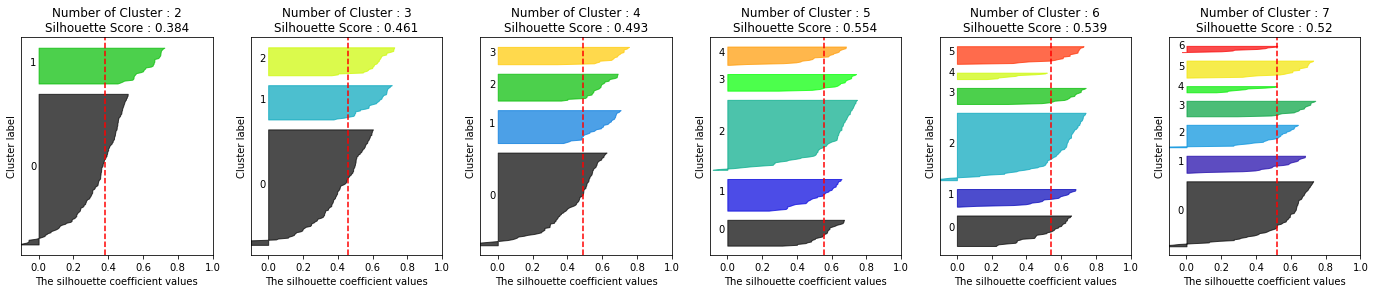

In [53]:
visualize_silhouette(['hierarchical', 'ward'], data1, [2,3,4,5,6,7])
visualize_silhouette(['hierarchical', 'ward'], data1_scaled, [2,3,4,5,6,7])

* 5개로 군집화 했을 때 가장 silhouette score가 높으며 지수가 음수인 경우도 드물어 보임.

In [54]:
params = {'n_clusters' : [2,3,4,5,6,7]}

scores_kmeans = {}

for n_cluster in params['n_clusters']:
    model = KMeans(n_clusters=n_cluster)
    model.fit(data1)
    score = silhouette_score(data1, model.labels_)
    scores_kmeans['_'.join(['original', str(n_cluster)])] = score
    
    model = KMeans(n_clusters=n_cluster)
    model.fit(data1_scaled)
    score = silhouette_score(data1_scaled, model.labels_)
    scores_kmeans['_'.join(['scaled', str(n_cluster)])] = score
    
pd.Series(scores_kmeans).sort_values(ascending=False)[:10]

scaled_5      0.554657
original_5    0.553932
original_6    0.539392
scaled_6      0.537714
scaled_7      0.526345
scaled_4      0.493907
original_4    0.493196
original_3    0.467614
scaled_3      0.466585
original_7    0.453328
dtype: float64

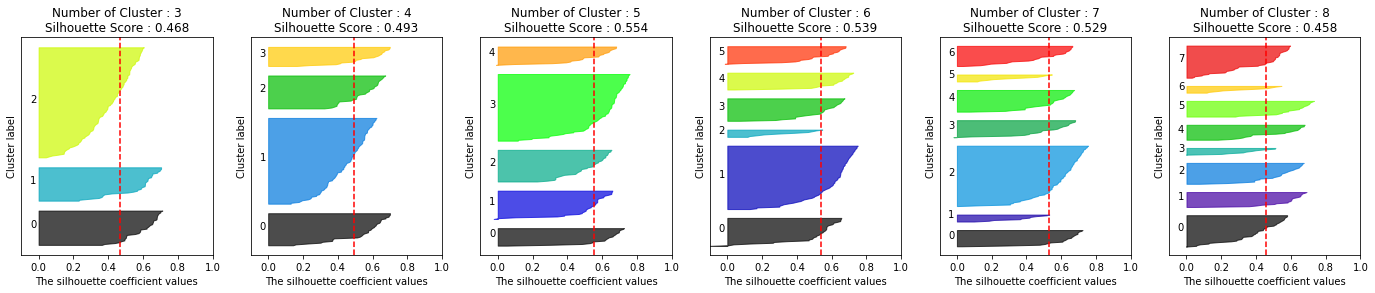

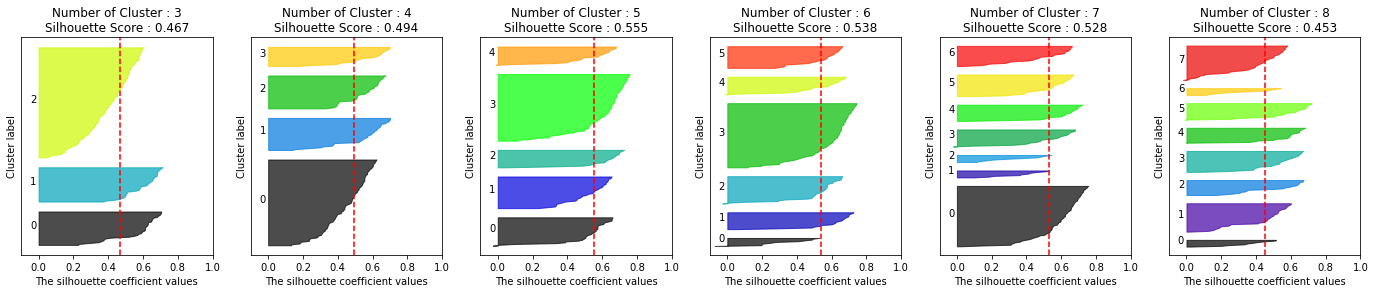

In [55]:
visualize_silhouette(['kmeans'], data1, [3,4,5,6,7,8])
visualize_silhouette(['kmeans'], data1_scaled, [3,4,5,6,7,8])

* scaled 된 데이터로 5개로 군집화했을 때 silhouette score가 가장 높음.

In [58]:
dbscan = DBSCAN(eps=0.8, min_samples=4)
dbscan.fit(db_data_scaled)
print(silhouette_score(db_data_scaled, dbscan.labels_))

0.26427795082030064


* 시각화 결과에서 딱히 군집화가 잘 되지 않았는데 silhouette score 또한 낮게 나옴.
* 본 데이터에는 DBSCAN이 적합하지 않은 것으로 보임.